# Active Learning through Dataset Reduction

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Machine Learning in the Design and Analysis for Steel Connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Simulations to establish best learning function, by reducing the dataset and strategically incrementing it, evaluating the DNN alongside.

**Dependencies**: 
- `DNN.py`
- `AL.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters

import DataReader
importlib.reload(DataReader)
from DataReader import DataReader

import DNN
importlib.reload(DNN)
from DNN import DNN

from Plot_Functions import plot_MV_interaction

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()

**BALD** (Bayesian Active Learning by Disagreement)

- Core idea: Select samples that maximize mutual information between predictions and model parameters.

- Equation: <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mtext>BALD</mtext><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mi mathvariant="double-struck">H</mi><mo stretchy="false">[</mo><mi>y</mi><mo>∣</mo><mi>x</mi><mo separator="true">,</mo><mi mathvariant="script">D</mi><mo stretchy="false">]</mo><mo>−</mo><msub><mi mathvariant="double-struck">E</mi><mi>w</mi></msub><mo stretchy="false">[</mo><mi mathvariant="double-struck">H</mi><mo stretchy="false">[</mo><mi>y</mi><mo>∣</mo><mi>x</mi><mo separator="true">,</mo><mi>w</mi><mo stretchy="false">]</mo><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">\text{BALD}(x) = \mathbb{H}[y \mid x, \mathcal{D}] - \mathbb{E}_{w}[\mathbb{H}[y \mid x, w]]</annotation></semantics></math>

- What it captures: It prefers points where the model is uncertain because it doesn’t know enough yet (epistemic uncertainty).

## Load Data

In [3]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx


In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


## Load Model

In [5]:
load_mode = True
model_name = "DNN_Model_Full_V2"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

if load_mode:
    model = DNN()
    model = torch.load(MODEL_SAVE_FILE)
    df = df_full.loc[model.data['data_indeces']]

    for key, value in model.config.items():
        print(key, value)

    print(model.data['data_reduction_factor'])

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization
0


## Visualize AL Approach

This approach is only for illustrative purposes to test the AL workflow on existing data.

Get uncertainty for all samples with:

In [6]:
df_data = df_full.loc[model.data['data_indeces']]
_, _, mc_preds = model.mc_dropout_uncertainty(df_data,num_samples=100, dropout_prob=0.1)

In [7]:
mc_pred_mean = mc_preds.mean(axis=0)
mc_pred_var = mc_preds.var(axis=0)
mc_pred_std = mc_preds.std(axis=0)
uncertainty = mc_pred_std / mc_pred_mean

In [8]:
uncertain_ids = np.argsort(uncertainty.flatten())[::-1]

In [9]:
y_preds, _ = model.predict(df_data)

In [10]:
error = y_preds.numpy().flatten() - df_full['target'].values
relative_error = error / df_full['target'].values

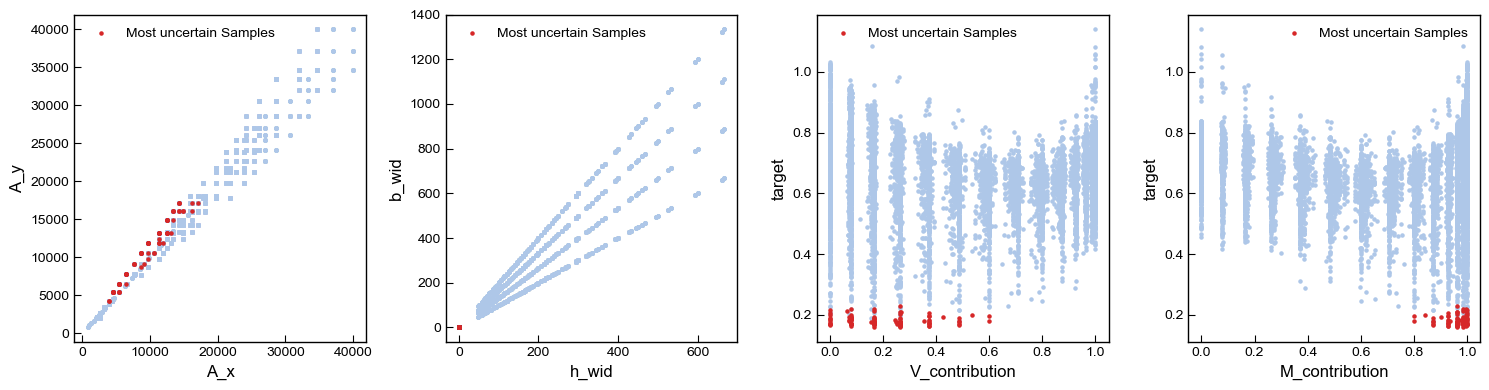

In [11]:
fig, axs = plt.subplots(1,4,figsize=(15,4))

cols_to_plot = [['A_x', 'A_y'],['h_wid','b_wid'], ['V_contribution', 'target'], ['M_contribution', 'target']]
uncertain_samples = df_data.iloc[uncertain_ids[:100]]
df_data_reduced = df_data.sample(10000)

for i,col in enumerate(cols_to_plot):
    ax = axs[i]
    ax.scatter(uncertain_samples[col[0]], uncertain_samples[col[1]], 
               s=5.0,
               c=plot_params.morecolors[6],
               label='Most uncertain Samples',
               zorder=2)
    ax.scatter(df_data_reduced[col[0]], df_data_reduced[col[1]], 
               c=plot_params.morecolors[1],
               s=5.0,
               zorder=0)
    ax.set_xlabel(col[0])
    ax.set_ylabel(col[1])
    ax.legend()

plt.tight_layout()
plt.show()

### Visualize Distances

In [12]:
df_reduced = df_full.sample(10000).copy()

In [8]:
def get_dists(sample, df):
    x_data = df[model.features].values
    x_sample = sample[model.features].values
    scaler = StandardScaler()
    x_data = scaler.fit_transform(x_data)
    x_sample = scaler.transform(x_sample.reshape(1, -1))
    distances = np.linalg.norm(x_data - x_sample, axis=1)
    return distances

In [14]:
base_sample = df_reduced.iloc[0].copy()
distances_to_base = get_dists(base_sample, df_reduced)

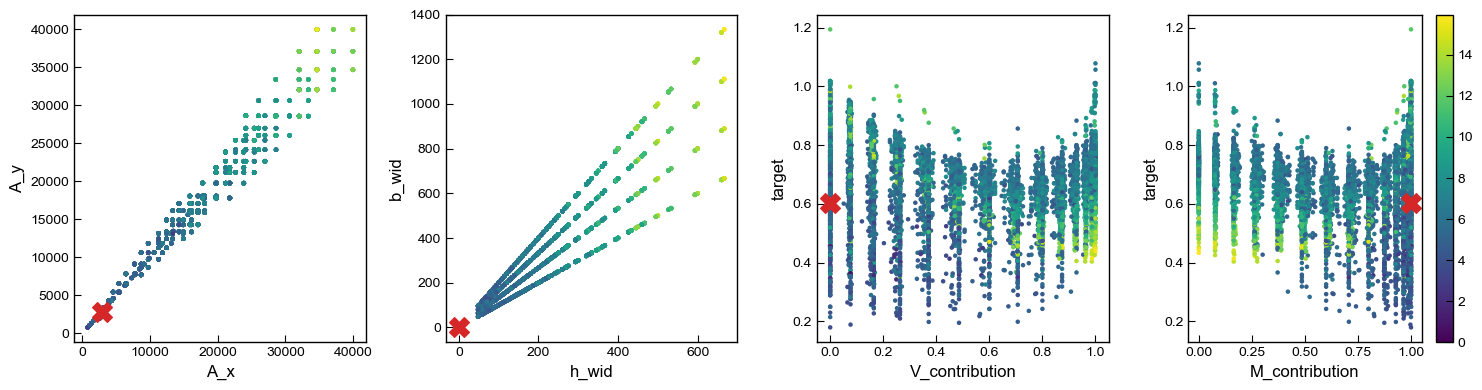

In [20]:
fig, axs = plt.subplots(1,4,figsize=(15,4))

cols_to_plot = [['A_x', 'A_y'],['h_wid','b_wid'], ['V_contribution', 'target'], ['M_contribution', 'target']]

for i,col in enumerate(cols_to_plot):
    ax = axs[i]
    sc = ax.scatter(df_reduced[col[0]], df_reduced[col[1]], 
               c=distances_to_base,
               s=5.0,
               zorder=0)
    ax.scatter(base_sample[col[0]], base_sample[col[1]],
               c=plot_params.colors[3],
               s=200.0,
               marker='X',
               zorder=2)
    ax.set_xlabel(col[0])
    ax.set_ylabel(col[1])

    if i == 3:
        plt.colorbar(sc,ax=ax)


plt.tight_layout()
plt.show()

### Visualize Sampling

Function to sample near another sample. Aim: If a sample from the training/test/val data is uncertain, add more samples near this sample.

In [9]:
def sample_near(sample, df, new_samples=1, return_distances=False):
    ids = df.index.values
    x_data = df[model.features].values

    x_sample = sample[model.features].values

    scaler = StandardScaler()
    x_data = scaler.fit_transform(x_data)
    x_sample = scaler.transform(x_sample.reshape(1, -1))

    distances = np.linalg.norm(x_data - x_sample, axis=1)
    closest_indices = np.argsort(distances)[:new_samples]

    new_ids = ids[closest_indices]

    if return_distances:
        return df.loc[new_ids], distances[closest_indices]
    else:
        return df.loc[new_ids]

In [42]:
n_base_samples = 1
sample_ids = uncertain_ids[[0,500,1000,20000]]
df_remaining = df_full.drop(sample_ids)
base_samples = [pd.DataFrame(df_full.iloc[id]).transpose() for id in sample_ids]
new_samples = [sample_near(base_sample, df_remaining, 10, return_distances=True) for base_sample in base_samples]

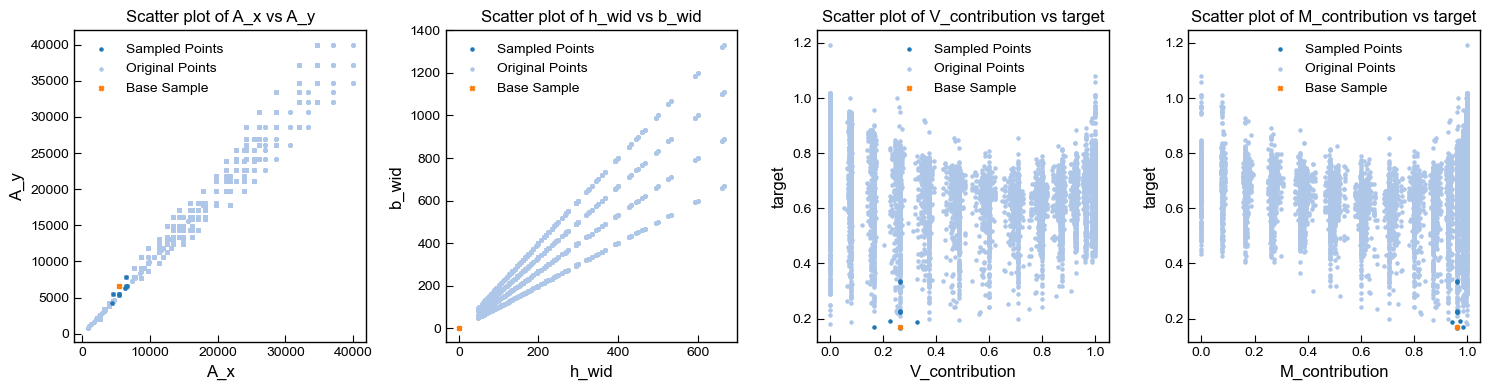

In [43]:
fig, axs = plt.subplots(1,4,figsize=(15,4))

cols_to_plot = [['A_x', 'A_y'],['h_wid','b_wid'], ['V_contribution', 'target'], ['M_contribution', 'target']]

for i,col in enumerate(cols_to_plot):
    ax = axs[i]
    ax.scatter(new_samples[0][0][col[0]], new_samples[0][0][col[1]], 
               s=5.0,
               c=plot_params.morecolors[0],
               label='Sampled Points',
               zorder=2)
    ax.scatter(df_reduced[col[0]], df_reduced[col[1]], 
               c=plot_params.morecolors[1],
               s=5.0,
               label='Original Points',
               zorder=0)
    ax.scatter(base_samples[0][col[0]], base_samples[0][col[1]], 
               c=plot_params.morecolors[2],
               marker='X',
               s=10.0,
               label='Base Sample',
               zorder=3)
    ax.set_xlabel(col[0])
    ax.set_ylabel(col[1])
    ax.legend()
    ax.set_title(f"Scatter plot of {col[0]} vs {col[1]}")

plt.tight_layout()
plt.show()

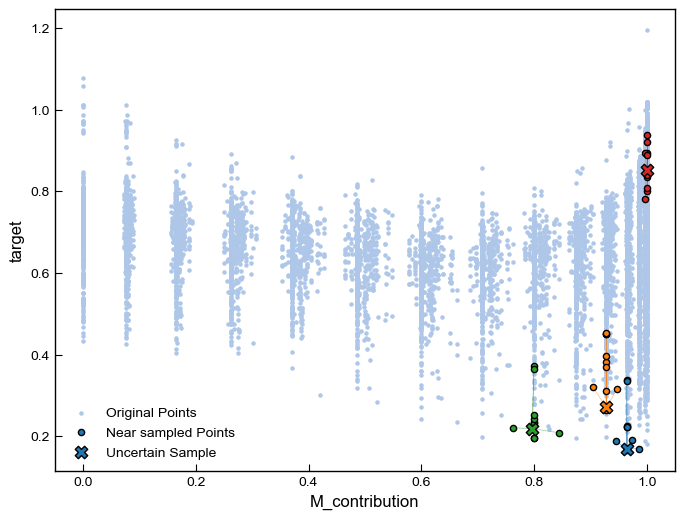

In [47]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(df_reduced['M_contribution'], df_reduced['target'], 
            s=5.0, 
            c=plot_params.morecolors[1], 
            label='Original Points', zorder=0)

for i, base_sample in enumerate(base_samples):
    new_sample = new_samples[i][0]
    label = None if i > 0 else 'Near sampled Points'
    ax.scatter(new_sample['M_contribution'], new_sample['target'], 
               s=20.0, 
               facecolor=plot_params.colors[i], 
               edgecolor='black',
               label=label, zorder=2)
    label = None if i > 0 else 'Uncertain Sample'
    ax.scatter(base_sample['M_contribution'], base_sample['target'], 
               facecolor=plot_params.colors[i],
               edgecolor='black',
               marker='X',
               s=80.0,
               label=label, zorder=3)

    for j,sample in new_sample.iterrows():
        ax.plot([base_sample['M_contribution'].values[0], sample['M_contribution']],
                [base_sample['target'].values[0], sample['target']], 
                c=plot_params.colors[i], 
                linewidth=0.5,
                alpha=0.5, zorder=1)

plt.legend()
plt.xlabel('M_contribution')
plt.ylabel('target')

plt.show()

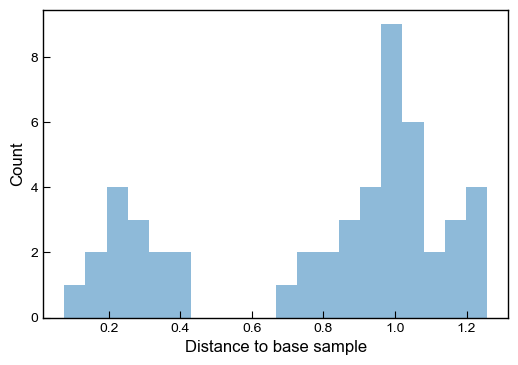

In [147]:
samples_distances = np.array([new_samples[i][1] for i in range(n_base_samples)])

fig, ax = plt.subplots(figsize=(6,4))

plt.hist(samples_distances.flatten(), bins=20, alpha=0.5, color=plot_params.colors[0])
plt.xlabel('Distance to base sample')
plt.ylabel('Count')

plt.show()


## Active Learning

Check the uncertainty of existing data (training data). Add more samples near points with high uncertainty.

In [10]:
initial_data = 50000
initial_epochs = 1000
add_uncertain_sample = 100
add_samples_near_uncertain = 100
epochs_per_iteration = 100
iterations = 50

df_test = df_full.loc[model.data['test_data']]
df_train = df_full.loc[model.data['train_data']]

df_initial = df_train.sample(n=initial_data, random_state=42).copy()
df_remaining = df_train.drop(df_initial.index).copy()

print(f'Maximal Epochs: {initial_epochs+epochs_per_iteration*iterations}')
print(f'Maximal final samples: {initial_data+add_samples_near_uncertain*add_uncertain_sample*iterations}')
print(f'Maximal added samples per iteration: {add_uncertain_sample*add_samples_near_uncertain}')

Maximal Epochs: 6000
Maximal final samples: 550000
Maximal added samples per iteration: 10000


In [90]:
metrics_log = {
    "y_preds":[],
    "y_truth":[],
    "uncertainty":[],
    "iteration": [],
    "R2":[]
}

log_every_n_iteration = 1

mc_std

In [ ]:
model_sim = copy.deepcopy(model)

model_sim.prepare_data(df_initial)
model_sim.build()

model_sim.data['data_indeces'] = df_initial.index.to_list()
model_sim.data['test_data'] = df_test.index.to_list()
model_sim.x_test, model_sim.y_test = model.x_test, model.y_test

model_sim.config['print_logs'] = False
model_sim.config['learning_rate'] = 0.005
model_sim.config['dropout_prob'] = 0.0

model_sim.config['epochs'] = initial_epochs
model_sim.train()

df_AL_train = df_initial.copy()

for i in range(iterations):
        print(f"Iteration {i + 1}")

        df_data = df_full.loc[model_sim.data['data_indeces']]
        print(f"Samples in data set: {df_data.shape[0]}")
        
        print('Get uncertainty')

        _, _, mc_preds = model_sim.mc_dropout_uncertainty(df_data, num_samples=100, dropout_prob=0.1)

        mc_pred_mean = mc_preds.mean(axis=0)
        mc_pred_std = mc_preds.std(axis=0)

        uncertainty = mc_pred_std/mc_pred_mean

        # Select the samples with the highest uncertainty
        uncertain_samples = np.argsort(uncertainty.flatten())[-add_uncertain_sample:].flatten()
        df_uncertain_samples = df_remaining.iloc[uncertain_samples]

        # Initialize an empty list to store the new samples
        df_new_samples = pd.DataFrame(columns=df_remaining.columns)

        print('Get new Samples')

        for index, row in df_uncertain_samples.iterrows():
                new_samples = sample_near(row, df_remaining, add_samples_near_uncertain)
                df_new_samples = pd.concat([df_new_samples,new_samples])

        # IMPORTANT: Get unique values, since samples could have been selected by multiple base points
        df_new_samples = df_new_samples.drop_duplicates()

        # Add these samples to the training set
        df_AL_train = pd.concat([df_AL_train, df_new_samples])

        # Remove the added samples from the original dataset
        df_remaining = df_remaining.drop(df_new_samples.index)

        print('Fine Tune Model')

        model_sim.fine_tune(df_new_samples, epochs=epochs_per_iteration)

        print('Get Model Metrics')

        metrics = model_sim.get_metrics()

        print(f"R2 = {metrics['R2']:.4f}, ")

        if i % log_every_n_iteration == 0:
            print('Log Model Metrics')
            y_pred, _ = model_sim.evaluate()
            y_true = model_sim.y_test.numpy()
            metrics_log['iteration'].append(i)      
            metrics_log['y_preds'].append(y_pred)
            metrics_log['y_truth'].append(y_true)
            metrics_log['uncertainty'].append(uncertainty)
            metrics_log['R2'].append(metrics['R2'])

Number of training samples: 80
Number of validation samples: 10
Number of testing samples: 10
Iteration 1
Samples in data set: 100
Get uncertainty
Get new Samples
Fine Tune Model
Get Model Metrics
R2 = -0.1241, 
Log Model Metrics
Iteration 2
Samples in data set: 198
Get uncertainty
Get new Samples
Fine Tune Model
Get Model Metrics
R2 = 0.3799, 
Log Model Metrics
Iteration 3
Samples in data set: 298
Get uncertainty
Get new Samples
Fine Tune Model
Get Model Metrics
R2 = 0.5809, 
Log Model Metrics
Iteration 4
Samples in data set: 398
Get uncertainty
Get new Samples
Fine Tune Model
Get Model Metrics
R2 = 0.6220, 
Log Model Metrics
Iteration 5
Samples in data set: 497
Get uncertainty
Get new Samples
Fine Tune Model
Get Model Metrics
R2 = 0.6313, 
Log Model Metrics


Check for duplicates:

In [83]:
exists = []
for i in model_sim.data['train_data']:
    if i in exists:
        print(i)
    exists.append(i)

#### Save Model

In [59]:
model_name = "DNN_Model_BALD_V3"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)

if not os.path.exists(MODEL_SAVE_PATH):
    os.mkdir(MODEL_SAVE_PATH)
else: 
    print('Models available to load:')
    for file in os.listdir("Saved Models"):
        print(file)

MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

model.save(MODEL_SAVE_FILE)

Models available to load:
CVAE_Model
CVAE_Simple
DNN_Model_BALD
DNN_Model_BALD_V2
DNN_Model_BALD_V3
DNN_Model_Full
DNN_Model_Full_AllFeatures
DNN_Model_Full_Extern
DNN_Model_Full_V2
DNN_Model_Hypercubes_m5
DNN_Model_LHS
Model saved to: Saved Models\DNN_Model_BALD_V3\DNN_Model_BALD_V3.pth


## Evaluate

In [103]:
model_sim.get_metrics()

{'MSE': 0.005499561,
 'RMSE': 0.074159026,
 'MAE': 0.0541969,
 'R2': 0.6312805116176605,
 'MCDMS': 0.016924626609085367,
 'MCDUS': 0.05785849371333877}

In [104]:
y_pred, _ = model_sim.evaluate()
y_true = model_sim.y_test.numpy()
_,_,mc_preds = model_sim.mc_dropout_uncertainty()
mc_pred_std = mc_preds.std(axis=0)
mc_pred_mean = mc_preds.mean(axis=0)
uncertainty = mc_pred_std/mc_pred_mean

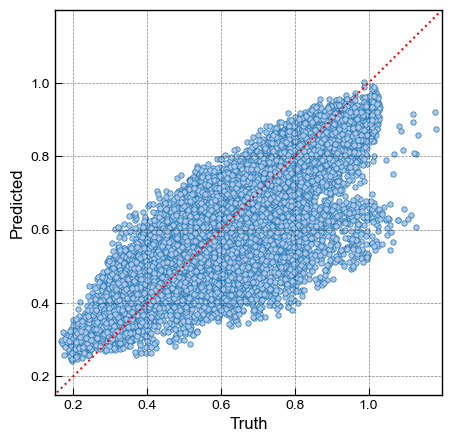

In [105]:
fig, ax = plt.subplots(figsize=(5,5))

plt.scatter(y_true, y_pred.numpy(), s=15, 
            facecolor=plot_params.morecolors[1], 
            edgecolors=plot_params.morecolors[0],
            linewidth=0.5,
            zorder=1)
plt.plot([-1,2], [-1, 2], 
         color='red',
         linestyle='dotted',
         linewidth=1.5, 
         zorder=2)

plt.xlim([0.9*min(y_true), max(y_true)+0.1*min(y_true)])
plt.ylim([0.9*min(y_true), max(y_true)+0.1*min(y_true)])

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

plt.ylabel("Predicted")
plt.xlabel("Truth")
plt.show()

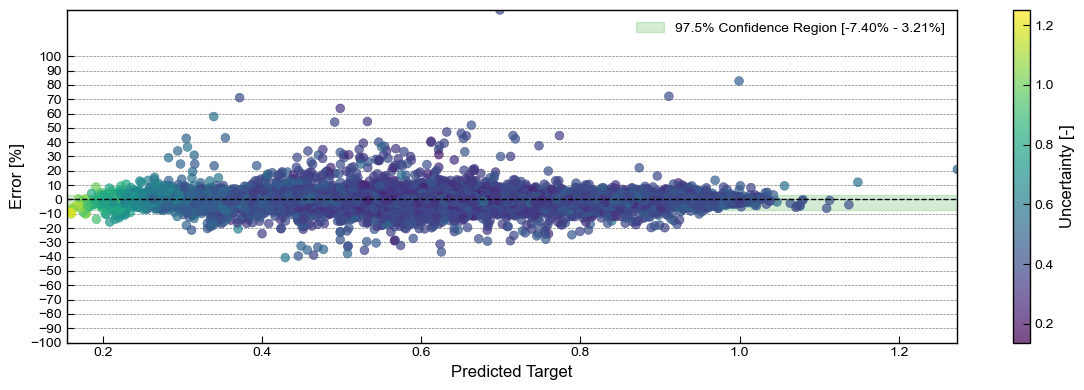

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))

preds_truth_ratio = y_pred / y_true
preds_truth_deviation = (preds_truth_ratio - 1)*100

confidence = 97.5

percentile_lower, percentile_upper = np.percentile(preds_truth_deviation, [(100-confidence)/2, confidence-(100-confidence)/2])

plt.scatter(y_pred, preds_truth_deviation,
            s=40, 
            c=uncertainty,
            linewidth=0.5,
            alpha=0.7,
            zorder=2)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0, zorder=2)

plt.fill_between(
    x=[0, 1.4],  # Cover full x-range
    y1=percentile_lower,
    y2=percentile_upper,
    color=plot_params.morecolors[4],
    alpha=0.2,
    label=f"{confidence}% Confidence Region [{percentile_lower:.2f}% - {percentile_upper:.2f}%]",
    zorder=0
)

plt.colorbar(label='Uncertainty [-]')

plt.xlabel("Predicted Target")
plt.ylabel("Error [%]")

plt.xlim([min(y_pred),max(y_pred)])
plt.ylim([-min(preds_truth_deviation),max(preds_truth_deviation)])

plt.yticks(np.arange(-100, 100+1, 10))
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

plt.legend()

plt.tight_layout()
plt.show()

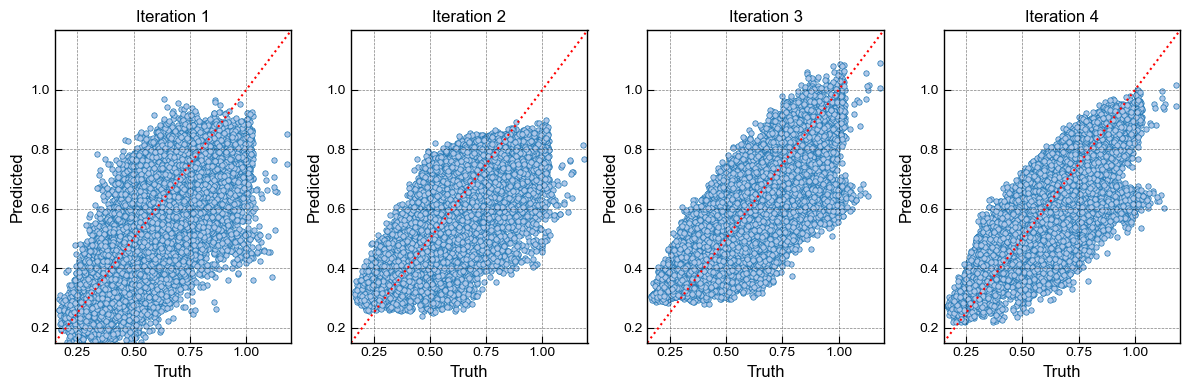

In [106]:
fig, axs = plt.subplots(1,4,figsize=(12,4))

plot_iterations = [0, 1, 2, 3]

for i,iter in enumerate(plot_iterations):
    y_pred = metrics_log['y_preds'][iter]
    y_true = metrics_log['y_truth'][iter]
    uncertainty = metrics_log['uncertainty'][iter]

    axs[i].scatter(y_true, y_pred.numpy(), s=15, 
                   facecolor=plot_params.morecolors[1], 
                   edgecolors=plot_params.morecolors[0],
                   linewidth=0.5,
                   zorder=1)
    axs[i].plot([-1,2], [-1, 2], 
                color='red',
                linestyle='dotted',
                linewidth=1.5, 
                zorder=2)

    axs[i].set_xlim([0.9*min(y_true), max(y_true)+0.1*min(y_true)])
    axs[i].set_ylim([0.9*min(y_true), max(y_true)+0.1*min(y_true)])

    axs[i].grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

    axs[i].set_ylabel("Predicted")
    axs[i].set_xlabel("Truth")
    axs[i].set_title(f"Iteration {iter+1}")

plt.tight_layout()
plt.show()


In [ ]:
uncertainty_evolution = np.array([metrics_log['uncertainty'][i].mean() for i in range(len(metrics_log['uncertainty']))])

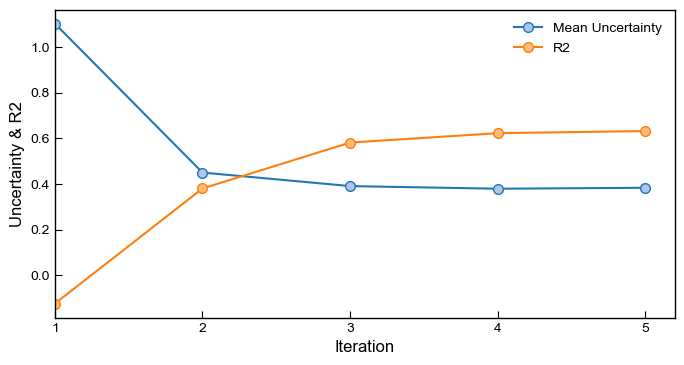

In [127]:
fig, ax = plt.subplots(figsize=(8,4))

plt.plot(np.arange(1, len(uncertainty_evolution)+1), uncertainty_evolution,
            color=plot_params.colors[0], 
            marker='o',
            markerfacecolor=plot_params.morecolors[1],
            markeredgecolor=plot_params.morecolors[0], 
            markersize=7, 
            label='Mean Uncertainty', zorder=2)
plt.plot(np.arange(1, len(metrics_log['R2'])+1), metrics_log['R2'],
            color=plot_params.colors[1], 
            marker='o', 
            markerfacecolor=plot_params.morecolors[3],
            markeredgecolor=plot_params.morecolors[2], 
            markersize=7, 
            label='R2', zorder=2)

plt.xlim([1,None])
plt.xticks(np.arange(1,len(metrics_log['R2'])+1))

plt.xlabel('Iteration')
plt.ylabel('Uncertainty & R2')
plt.legend()
plt.show()

Visualize the data chosen

## Approach 2 (WIP)

Get uncertainty over whole design domain and add points in regions with high uncertainty.

In [ ]:
from Helper_Functions import analyze_hypercube_density

In [ ]:
features = model.features
m = 5

In [ ]:
data = df_full[features].values
results = analyze_hypercube_density(data, num_bins=m)

Analyzing hypercube density with 714,385 points
Number of occupied hypercubes: 175,673 out of 95,367,431,640,625
Occupancy rate: 0.00000018%
Average points per occupied hypercube: 4.07
Maximum points in any hypercube: 176
Estimated empty hypercubes: 95,367,431,464,952
Estimated empty percentage: 99.9999998158%


In [ ]:
non_empty_hypercubes = list(results['hypercubes'].keys())
non_empty_hypercubes = np.array(non_empty_hypercubes)

hypercube_indices = results['hypercube_indices']
hypercube_unique = np.unique(hypercube_indices, axis=0)

hypercube_map = defaultdict(list)

for idx, cube in enumerate(map(tuple, hypercube_indices)):
    hypercube_map[cube].append(idx)

hypercube_contents = [np.array(hypercube_map[tuple(cube)]) for cube in hypercube_unique]

In [ ]:
upper_bound = np.max(df_full[features].values, axis=0)
lower_bound = np.min(df_full[features].values, axis=0)

edges = np.array([np.linspace(lower_bound[i], upper_bound[i], m+1) for i in range(len(features))])

Draws a random sample (uniform) from a given hypercube. The drawn sample should be somewhat feasible, since it will represent the data distribution in the hypercube space.

In [ ]:
def draw_sample_from_hypercube(hypercube):
    hypercube_index = np.where(np.all(hypercube_unique == hypercube, axis=1))[0][0]
    hypercube_coordinates = hypercube_unique[hypercube_index]
    lower_hypercube_bound = np.array([edges[i,index] for i,index in enumerate(hypercube_coordinates)])
    upper_hypercube_bound = np.array([edges[i,index+1] for i,index in enumerate(hypercube_coordinates)])
    random_sample = np.random.uniform(lower_hypercube_bound, upper_hypercube_bound)
    return random_sample

### Illustrate

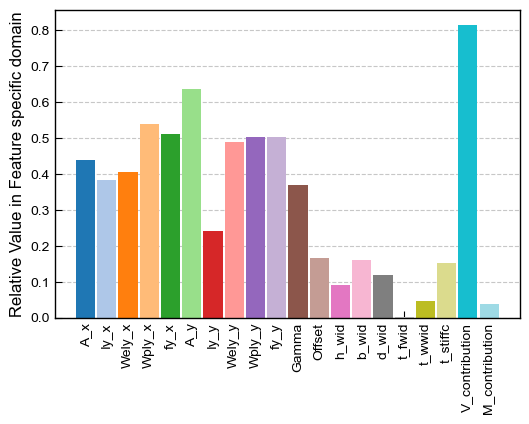

In [ ]:
drawn_sample = draw_sample_from_hypercube(non_empty_hypercubes[np.random.randint(0, len(non_empty_hypercubes))])

fig, ax = plt.subplots(figsize=(6, 4))

drawn_sample_norm = (drawn_sample - lower_bound) / (upper_bound - lower_bound)
plt.bar(np.arange(len(drawn_sample)),
        drawn_sample_norm, width=0.9,
        zorder=2,
        color=plot_params.morecolors[:len(features)])

plt.ylabel('Relative Value in Feature specific domain')

plt.xticks(np.arange(len(drawn_sample)), features, rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.show()

In [ ]:
samples = np.array([draw_sample_from_hypercube(non_empty_hypercubes[np.random.randint(0, len(non_empty_hypercubes))]) for _ in range(1000)])

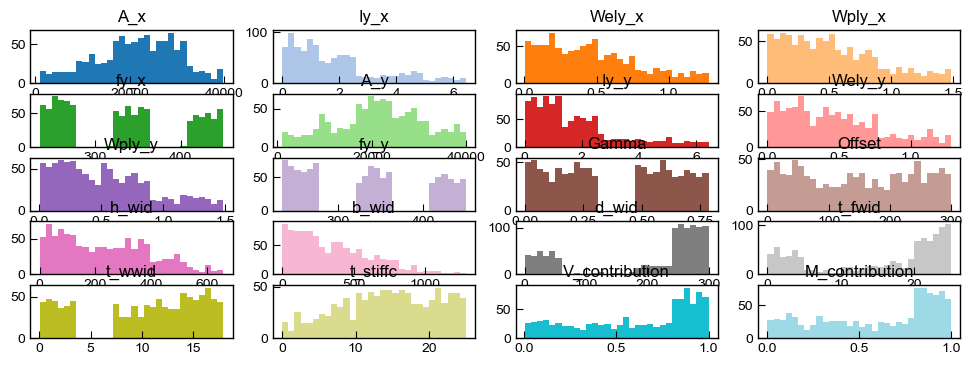

In [ ]:
fig, axs = plt.subplots(int(len(features)/4),4,figsize=(12,4))

for i, feature in enumerate(features):
    ax = axs[i//4, i%4]
    ax.hist(samples[:,i], bins=30, color=plot_params.morecolors[i])
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

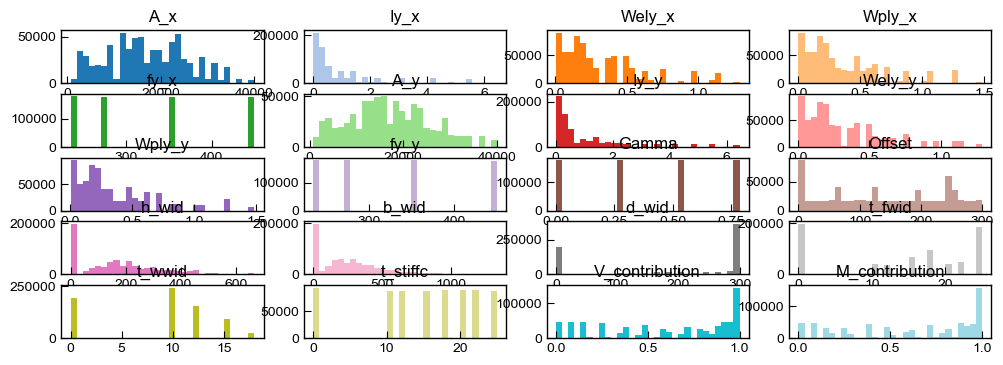

In [ ]:
fig, axs = plt.subplots(int(len(features)/4),4,figsize=(12,4))

for i, feature in enumerate(features):
    ax = axs[i//4, i%4]
    ax.hist(data[:,i], bins=30, color=plot_params.morecolors[i])
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

### Create Sampling Template for whole design domain

In [ ]:
def design_space_sampling():
    design_space_samples = []
    for hypercube in hypercube_unique:
        lower_hypercube_bound = np.array([edges[i,index] for i,index in enumerate(hypercube)])
        upper_hypercube_bound = np.array([edges[i,index+1] for i,index in enumerate(hypercube)])
        random_sample = np.random.uniform(lower_hypercube_bound, upper_hypercube_bound)
        design_space_samples.append(random_sample)
    return design_space_samples

In [ ]:
design_domain_samples = design_space_sampling()

In [ ]:
scaler = StandardScaler()

In [ ]:
x_domain = scaler.fit_transform(design_domain_samples)

In [ ]:
x_domain = 

(175673, 20)

In [ ]:
initial_data = 2000
initial_epochs = 200
add_uncertain_sample = 1
add_samples_near_uncertain = 10
epochs_per_iteration = 25
iterations = 50

df_initial = df_reduced.sample(n=initial_data, random_state=42)
df_remaining = df_reduced.drop(df_initial.index)

In [ ]:
model_sim = copy.deepcopy(model)

model_sim.prepare_data(df_initial)
model_sim.build()

model_sim.config['print_logs'] = False

model_sim.config['epochs'] = initial_epochs
model_sim.train()

Number of training samples: 1600
Number of validation samples: 200
Number of testing samples: 200


In [ ]:
x_data = torch.tensor(x_domain, dtype=torch.float32)

### Check initial uncertainty distribution

In [ ]:
_, _, mc_preds = model_sim.mc_dropout_uncertainty(X_input = x_data, num_samples=100, dropout_prob=0.1)

In [ ]:
mc_preds_var = mc_preds.var(axis=0)

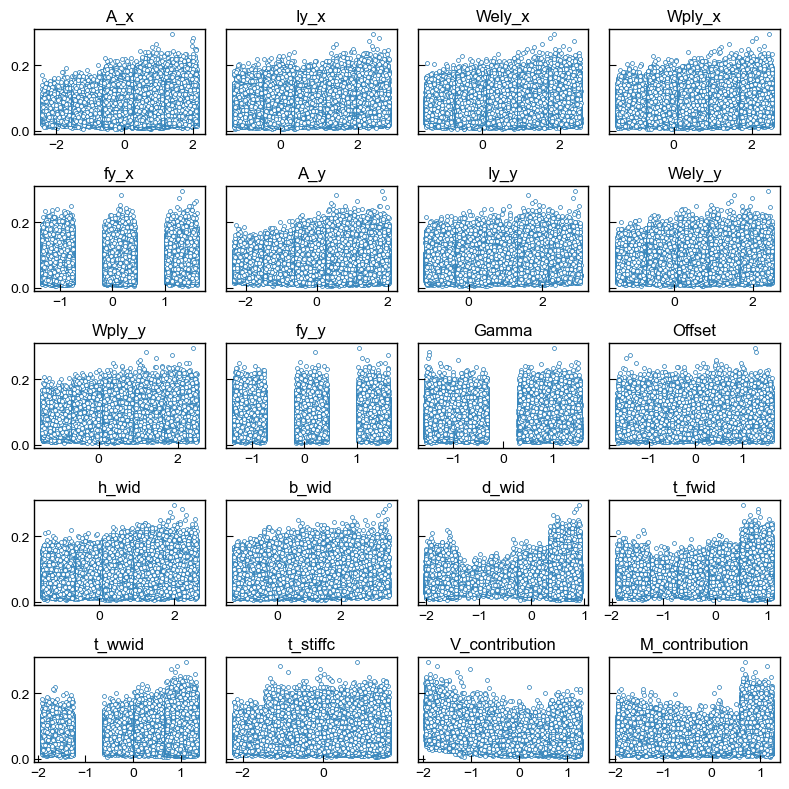

In [ ]:
fig, axs = plt.subplots(int(len(model.features)/4),4, figsize=(8,8), sharey=True)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax.scatter(x_data.numpy()[:,i], mc_preds_var, 
               s=8, 
               edgecolor=plot_params.morecolors[0],
               linewidth=0.5,
               facecolor='white')
    ax.set_title(feature)

plt.tight_layout()
plt.show()

### Active Learning

In [ ]:
map_sample_to_hypercube = []

for hypercube_id, samples in enumerate(hypercube_contents):
    for _, sample_id in enumerate(samples):
        map_sample_to_hypercube.append([sample_id, hypercube_id])

In [ ]:
map_sample_to_hypercube = np.array(map_sample_to_hypercube)

In [ ]:
sorted_map = map_sample_to_hypercube[np.argsort(map_sample_to_hypercube[:, 0])]

In [ ]:
lookup_hypercubes = sorted_map[:,1]

In [ ]:
def draw_real_samples_from_hypercube(hypercube_ids):
    real_samples = []
    for hypercube_id in hypercube_ids:
        samples_in_hypercube = hypercube_contents[hypercube_id]
        random_sample_id = np.random.choice(samples_in_hypercube)
        real_samples.append(random_sample_id)

    return real_samples

In [ ]:
uncertain_hypercube_ids = np.argsort(mc_pred_var)[-add_uncertain_sample:].flatten()
samples_ids_from_hypercubes = draw_real_samples_from_hypercube(uncertain_hypercube_ids)

In [ ]:
df_train = df_initial.copy()

for i in range(iterations):
    print(f"Iteration {i + 1}")

    print(f"Samples in data set: {model.x_data.shape[0]}")

    _, _, mc_preds = model_sim.mc_dropout_uncertainty(X_input = x_data, num_samples=100, dropout_prob=0.1)

    mc_pred_mean = mc_preds.mean(axis=0)
    mc_pred_var = mc_preds.var(axis=0)

    # Select the samples with the highest uncertainty
    uncertain_hypercube_ids = np.argsort(mc_pred_var)[-add_uncertain_sample:].flatten()
    samples_ids_from_hypercubes = draw_real_samples_from_hypercube(uncertain_hypercube_ids)
    
    df_uncertain_samples = df_remaining.loc[samples_ids_from_hypercubes]

    # Initialize an empty list to store the new samples
    new_samples_list = []

    # Assuming `df_uncertain_samples` and `df_remaining` are already DataFrames
    for index, row in df_uncertain_samples.iterrows():
        new_samples = sample_near(row, df_remaining, add_samples_near_uncertain)
        new_samples_list.append(new_samples)

    # Convert the list of new samples to a DataFrame and assign to df_new_samples
    df_new_samples = pd.concat(new_samples_list)

    # Add these samples to the training set
    df_train = pd.concat([df_train, df_new_samples])

    # Remove the added samples from the original dataset
    df_remaining = df_remaining.drop(df_new_samples.index)

    model_sim.fine_tune(df_train, epochs=epochs_per_iteration)

    metrics = model_sim.get_metrics()

    print(f"R2 = {metrics['R2']:.4f}, ")

   # Potting the results
    fig, axs = plt.subplots(1,4,figsize=(12,4))
    cols_to_plot = [['A_x', 'A_y'],['h_wid','b_wid'],['V_contribution', 'target'],['M_contribution', 'target']]

    for i,col in enumerate(cols_to_plot):
        ax = axs[i]
        ax.scatter(new_samples[col[0]], new_samples[col[1]], 
                s=5.0,
                c=plot_params.morecolors[0],
                label='Added Samples',
                zorder=2)
        ax.scatter(df_train[col[0]], df_train[col[1]], 
                c=plot_params.morecolors[1],
                s=5.0,
                label='Training Samples',
                zorder=1)
        ax.scatter(df_reduced[col[0]], df_reduced[col[1]], 
                edgecolor=plot_params.morecolors[15],
                facecolor='white',
                linewidth=0.5,
                s=5.0,
                label='Available Samples',
                zorder=0)
        ax.scatter(df_uncertain_samples[col[0]], df_uncertain_samples[col[1]], 
                c=plot_params.morecolors[6],
                s=10.0,
                label='Base Samples',
                zorder=3)
        ax.set_xlabel(col[0])
        ax.set_ylabel(col[1])
        ax.set_xticks([])
        ax.set_yticks([])

    ax.legend()
    plt.tight_layout()
    plt.show()

Iteration 1
Samples in data set: 175673


IndexError: positional indexers are out-of-bounds